# QMF: Final Project

*By Basri, Clara, Daniel, Elisa, José, Karim, Nani*

In [1]:
from datetime import timedelta

import arch
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Ubuntu',
    'font.monospace': 'Ubuntu Mono',
    'font.size': 14,

    'axes.labelweight': 'normal',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlesize': 16,
    'axes.titlelocation': 'center',
    'axes.labelpad': 10,
    'axes.titleweight': 'bold',
    'axes.titlepad': 15,
    
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    
    'figure.titlesize': 18,
    'figure.figsize': (10, 6),
    'figure.autolayout': True,
    'figure.subplot.wspace': 0.25,
    'figure.subplot.wspace': 0.4,

    'lines.linewidth': 2
})

## Data Loading

In [3]:
# load stocks from yahoo finance
prices = yf.download(
    "BNP.PA ACA.PA GLE.PA CS.PA AMUN.PA CNP.PA ^VIX ^STOXX50E",
    start="2017-06-01")['Close']

# calculate daily returns
returns = (prices / prices.shift(1) - 1)

# format date column and drop nan values
prices = prices.reset_index().rename(columns = {'Date': 'date'})
returns = returns.dropna().reset_index().rename(columns = {'Date': 'date'})

[*********************100%***********************]  8 of 8 completed


In [4]:
df_covid_vaccines = pd.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/fa4ad329-14ec-4394-85a4-c5df33769dff", 
    sep=';', 
    names=['fra', 'date', '_', '__', '___', 'n_first_dose', 'n_second_dose', 'n_third_dose', '____', '_____', '______'], 
    usecols=['date', 'n_first_dose', 'n_second_dose', 'n_third_dose'], 
    skiprows=1, 
    parse_dates=['date']
)

In [5]:
df_covid_indicators = pd.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/f335f9ea-86e3-4ffa-9684-93c009d5e617", 
    usecols=['date', 'dc_tot', 'pos', 'TO', 'R'],  
    parse_dates=['date']
)
df_covid_indicators.rename(columns={'date': 'date', 'dc_tot': 'n_deaths', 'pos': 'n_cases', 'TO': 'hosp_occupation_rate', 'R': 'virus_reproduction_factor'}, inplace=True)
df_covid_indicators.fillna(0, inplace=True)

In [6]:
df_covid_measures_france = pd.read_csv(
    'datasets/covid_measures.csv',
    names = [
        'date', 'schools_closed', 'restaurants_museums_closed',
        'lockdown', 'curfew', 'travel_restriction',
        'emergency', 'lift_emergency', 'health_pass'
        ],
    parse_dates=[0],
    skiprows=1
    )

In [7]:
df_world_news = pd.read_csv('datasets/international_news.csv', sep=';', parse_dates=[0]).rename(columns={'Dates': 'date'})

#### Save useful data in a csv

In [8]:
# merge dataframes
csv = pd.merge(df_covid_indicators, df_covid_vaccines, on='date', how='left').fillna(0).iloc[:-1]
csv = csv.merge(prices, how='right').fillna(0)

# create var for new vaccines
csv['new_vaccines'] = (csv['n_first_dose'] + csv['n_second_dose'] + csv['n_third_dose']).diff()
csv.dropna(inplace=True)
csv = csv.iloc[:-3]

# save data in csv file
csv.to_csv('datasets/full_data.csv')

## Data Processing

### Calculate abnormal returns

In [9]:
window = 244
abn_returns = pd.DataFrame(index = returns.date)
stocks = ['ACA.PA', 'AMUN.PA', 'BNP.PA', 'CNP.PA', 'CS.PA', 'GLE.PA']

for stock in stocks:
    for t in range(window, len(returns)):
        past_values = returns.iloc[t-window: t-5].copy()
        past_values['const'] = 1
        
        results = sm.OLS(past_values[stock], past_values[['const', '^STOXX50E']]).fit()
        alpha = results.params[0]
        beta = results.params[1]

        current_date = returns['date'].iloc[t]
        abn_returns.loc[current_date, stock] = returns[stock].iloc[t] - alpha - beta*returns['^STOXX50E'].iloc[t]

abn_returns = abn_returns.dropna()
abn_returns['avg_abn_returns'] = abn_returns.mean(axis=1)
abn_returns = abn_returns.reset_index()

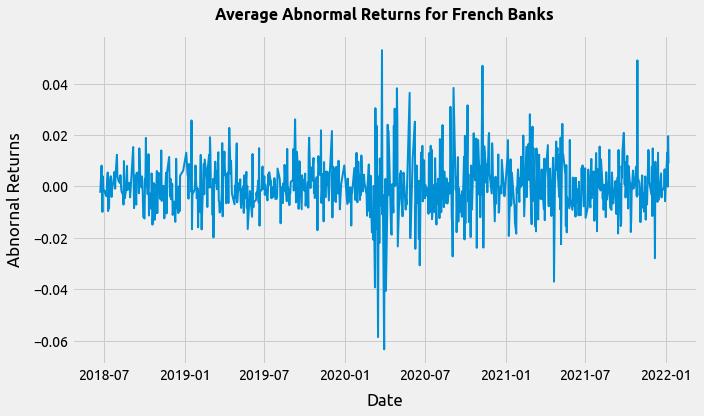

In [10]:
# plot abnormal returns
plt.figure()

plt.title('Average Abnormal Returns for French Banks')
plt.plot(abn_returns['date'], abn_returns['avg_abn_returns'])
plt.ylabel('Abnornal Returns')
plt.xlabel('Date')

plt.show()

### Merge all dataframes

In [11]:
# merge dataframes
df = pd.merge(df_covid_indicators, df_covid_vaccines, on='date', how='left').fillna(0).iloc[:-1]
df = df.merge(abn_returns[['date', 'avg_abn_returns']], how='left').dropna()
df = df.merge(df_covid_measures_france, how='inner')
df = df.merge(df_world_news, how='left')

# create var for new vaccines
df['new_vaccines'] = (df['n_first_dose'] + df['n_second_dose'] + df['n_third_dose']).diff()
df.dropna(inplace=True)

## Univariate Data Analysis

### Visualizing raw data 

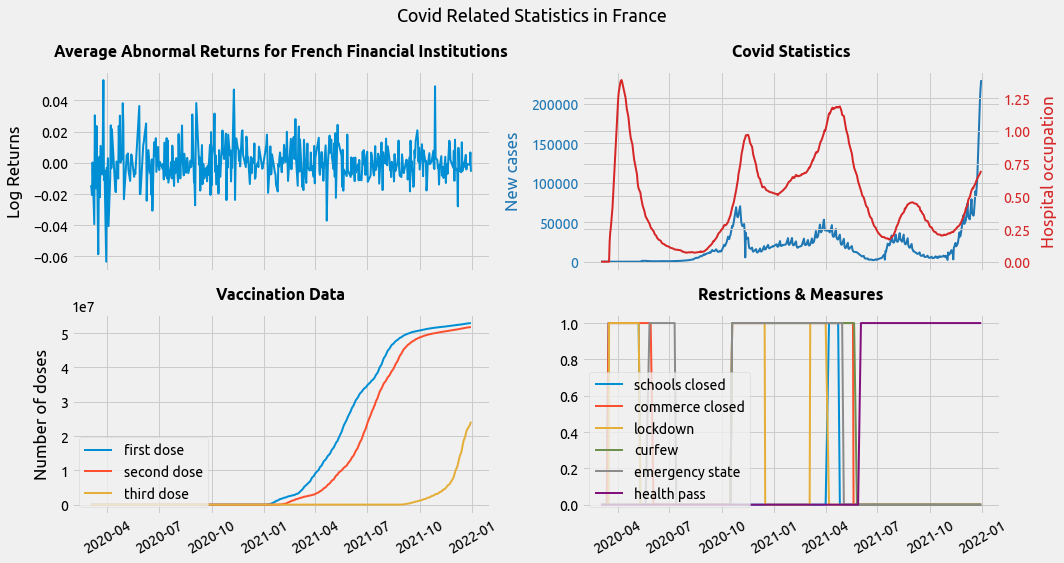

In [12]:
fig, ax = plt.subplots(2,2,sharex=True, figsize=(15,8))

ax[0,0].plot(df['date'], df['avg_abn_returns'])
ax[0,0].set_title('Average Abnormal Returns for French Financial Institutions')
ax[0,0].set_ylabel('Log Returns')

ax[1,0].plot(df['date'], df['n_first_dose'], df['date'], df['n_second_dose'], df['date'], df['n_third_dose'])
ax[1,0].legend(['first dose', 'second dose', 'third dose'], loc='lower left')
ax[1,0].set_title('Vaccination Data')
ax[1,0].set_ylabel('Number of doses')
ax[1,0].tick_params(axis='x', labelrotation = 30)

ax[0,1].plot(df['date'], df['n_cases'], c='tab:blue')
ax2 = ax[0,1].twinx()
ax2.plot(df['date'], df['hosp_occupation_rate'], c='tab:red')
ax[0,1].set_title('Covid Statistics')
ax[0,1].set_ylabel('New cases', color='tab:blue')
ax[0,1].tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylabel('Hospital occupation', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax[1,1].plot(
    df['date'], df['schools_closed'], 
    df['date'], df['restaurants_museums_closed'],
    df['date'], df['lockdown'],
    df['date'], df['curfew'],
    df['date'], df['emergency'],
    df['date'], df['health_pass']
)
ax[1,1].legend([
    'schools closed',
    'commerce closed',
    'lockdown',
    'curfew',
    'emergency state',
    'health pass'
], loc='lower left')
ax[1,1].set_title('Restrictions & Measures')
ax[1,1].tick_params(axis='x', labelrotation = 30)

fig.suptitle('Covid Related Statistics in France')
plt.tight_layout()
plt.show()

### Analysing correlation between variables

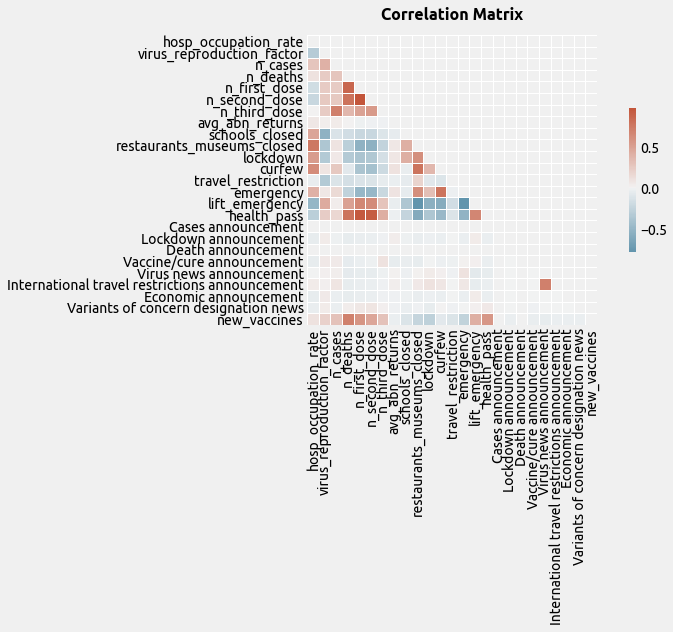

In [13]:
f, ax = plt.subplots(figsize=(11, 9))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=.5, 
    cbar_kws={"shrink": .5}
    )

plt.title('Correlation Matrix')
plt.show()

## Event Studies for Specific Dates

In [14]:
returns.set_index('date', inplace=True)

In [15]:
# calculate p-value for t-stats
def p_value(t_stat):
    return 2*(1-stats.t.cdf(abs(t_stat), df=estimation_window-1))

In [16]:
def event_study(event_date, estimation_window, event_window):
    
    # initialize vars
    event_date = pd.to_datetime(event_date)

    estimation_start = event_date - timedelta(estimation_window + event_window)
    estimation_end = event_date - timedelta(event_window + 1)

    event_start = event_date - timedelta(event_window)
    event_end = event_date + timedelta(event_window + 1)

    stocks = ['ACA.PA', 'AMUN.PA', 'BNP.PA', 'CNP.PA', 'CS.PA', 'GLE.PA']
    abn_returns = pd.DataFrame()
    estimation_abn_returns = pd.DataFrame()

    # calculate for every stock
    for stock in stocks:

        # estimate market model for return expectation using estimation window
        past_values = returns[estimation_start:estimation_end].copy()
        past_values['const'] = 1
        
        results = sm.OLS(past_values[stock], past_values[['const', '^STOXX50E']]).fit()
        alpha = results.params[0]
        beta = results.params[1]

        # calculate abnormal returns for estimation window
        estimation_abn_returns[stock] = returns[estimation_start:estimation_end][stock] - alpha - beta*returns[estimation_start:estimation_end]['^STOXX50E']
        
        # calculate abnormal returns for event window
        abn_returns[stock] = returns[event_start:event_end][stock] - alpha - beta*returns[event_start:event_end]['^STOXX50E']

    # calculate average and cumulative average abnormal returns
    abn_returns['avg'] = abn_returns.mean(axis=1)
    abn_returns['cum_avg'] = abn_returns['avg'].cumsum()

    # calculate aggregate estimation standard deviation
    agg_estimation_std = np.sqrt((estimation_abn_returns.std()**2).sum())/(len(stocks))

    # calculate t-stat for average and cumulative average abnormal returns
    abn_returns['avg_t'] = abn_returns['avg']/agg_estimation_std

    N = (event_end - event_start).days
    abn_returns['cum_avg_t'] = abn_returns['cum_avg']/(agg_estimation_std*np.sqrt(N))

    # calculate p-value for t-stats
    abn_returns['avg_p'] = abn_returns['avg_t'].apply(p_value)
    abn_returns['cum_avg_p'] = abn_returns['cum_avg_t'].apply(p_value)

    # print results
    res = abn_returns[['avg', 'avg_t', 'avg_p', 'cum_avg', 'cum_avg_t', 'cum_avg_p']].copy()
    res.rename(columns={
        'avg': 'AAR',
        'avg_t': 'AAR t-value',
        'avg_p': 'AAR p-value',
        'cum_avg': 'CAAR',
        'cum_avg_t': 'CAAR t-value',
        'cum_avg_p': 'CAAR p-value',
    }, inplace=True)
    print(res[['AAR', 'CAAR']].describe())
    return res.round(4)
        

#### Date: 07/01/2020

In [17]:
# define event date and time windows
event_date = '2020-01-07'
estimation_window = 90
event_window = 15

res = event_study(event_date, estimation_window, event_window)
res.to_csv(f'datasets/events/{event_date}.csv')
res

             AAR       CAAR
count  14.000000  14.000000
mean   -0.002660  -0.018326
std     0.005727   0.016965
min    -0.016501  -0.042564
25%    -0.003415  -0.036648
50%    -0.003075  -0.015280
75%    -0.000422  -0.003247
max     0.006091   0.005617


,AAR,AAR t-value,AAR p-value,CAAR,CAAR t-value,CAAR p-value
date,,,,,,
2019-12-23,-0.0005,-0.1151,0.9087,-0.0005,-0.0207,0.9836
2019-12-30,0.0061,1.4789,0.1427,0.0056,0.2450,0.8071
2020-01-06,-0.0086,-2.0811,0.0403,-0.0030,-0.1288,0.8978
2020-01-07,0.0018,0.4442,0.6580,-0.0011,-0.0491,0.9610
2020-01-08,-0.0030,-0.7286,0.4682,-0.0041,-0.1799,0.8576
2020-01-09,-0.0072,-1.7403,0.0853,-0.0113,-0.4925,0.6236
2020-01-10,-0.0031,-0.7649,0.4464,-0.0144,-0.6299,0.5304
2020-01-13,-0.0017,-0.4069,0.6850,-0.0161,-0.7029,0.4839
2020-01-14,-0.0035,-0.8425,0.4018,-0.0196,-0.8543,0.3953


#### Date: 16/03/2020

In [18]:
# define event date and time windows
event_date = '2020-03-16'
estimation_window = 90
event_window = 15

res = event_study(event_date, estimation_window, event_window)
res.to_csv(f'datasets/events/{event_date}.csv')
res

             AAR       CAAR
count  23.000000  23.000000
mean   -0.007633  -0.112303
std     0.030030   0.050568
min    -0.065061  -0.182945
25%    -0.018832  -0.156777
50%    -0.012635  -0.112530
75%     0.004024  -0.075406
max     0.061975  -0.016913


,AAR,AAR t-value,AAR p-value,CAAR,CAAR t-value,CAAR p-value
date,,,,,,
2020-03-02,-0.0169,-3.9577,0.0002,-0.0169,-0.7108,0.4791
2020-03-03,-0.0126,-2.9566,0.0040,-0.0295,-1.2418,0.2176
2020-03-04,-0.0135,-3.1672,0.0021,-0.0431,-1.8107,0.0736
2020-03-05,-0.0221,-5.1737,0.0000,-0.0652,-2.7399,0.0074
2020-03-06,-0.0050,-1.1674,0.2462,-0.0702,-2.9496,0.0041
2020-03-09,-0.0504,-11.7901,0.0000,-0.1206,-5.0672,0.0000
2020-03-10,0.0287,6.7185,0.0000,-0.0919,-3.8605,0.0002
2020-03-11,0.0091,2.1249,0.0364,-0.0828,-3.4788,0.0008
2020-03-12,-0.0298,-6.9625,0.0000,-0.1125,-4.7293,0.0000


#### Date: 11/07/2020

In [19]:
# define event date and time windows
event_date = '2020-07-11'
estimation_window = 90
event_window = 15

res = event_study(event_date, estimation_window, event_window)
res.to_csv(f'datasets/events/{event_date}.csv')
res

             AAR       CAAR
count  20.000000  20.000000
mean   -0.000261   0.002395
std     0.009661   0.006693
min    -0.013388  -0.008266
25%    -0.008736  -0.001892
50%    -0.002117   0.002267
75%     0.004629   0.005439
max     0.017855   0.019206


,AAR,AAR t-value,AAR p-value,CAAR,CAAR t-value,CAAR p-value
date,,,,,,
2020-06-26,-0.0044,-0.4339,0.6654,-0.0044,-0.0779,0.9381
2020-06-29,0.0101,1.0035,0.3183,0.0058,0.1023,0.9187
2020-06-30,-0.0004,-0.0421,0.9665,0.0053,0.0948,0.9247
2020-07-01,-0.0034,-0.3345,0.7388,0.0020,0.0347,0.9724
2020-07-02,-0.0012,-0.1209,0.9041,0.0007,0.0130,0.9897
2020-07-07,-0.0019,-0.1858,0.8530,-0.0011,-0.0204,0.9838
2020-07-08,0.0016,0.1560,0.8764,0.0004,0.0076,0.9939
2020-07-09,-0.0087,-0.8602,0.3920,-0.0083,-0.1469,0.8836
2020-07-10,0.0131,1.2934,0.1992,0.0048,0.0854,0.9321


#### Date: 17/10/2020

In [20]:
# define event date and time windows
event_date = '2020-10-17'
estimation_window = 90
event_window = 15

res = event_study(event_date, estimation_window, event_window)
res.to_csv(f'datasets/events/{event_date}.csv')
res

             AAR       CAAR
count  22.000000  22.000000
mean    0.004039   0.051813
std     0.013175   0.022055
min    -0.024822   0.005766
25%    -0.002354   0.035109
50%     0.005455   0.055266
75%     0.010298   0.063510
max     0.033372   0.088867


,AAR,AAR t-value,AAR p-value,CAAR,CAAR t-value,CAAR p-value
date,,,,,,
2020-10-02,0.0058,0.9135,0.3634,0.0058,0.1641,0.8700
2020-10-05,0.0150,2.3790,0.0195,0.0208,0.5914,0.5558
2020-10-06,0.0334,5.2872,0.0000,0.0542,1.5410,0.1269
2020-10-07,-0.0048,-0.7579,0.4505,0.0494,1.4048,0.1636
2020-10-08,0.0070,1.1104,0.2698,0.0564,1.6043,0.1122
2020-10-09,-0.0119,-1.8881,0.0623,0.0445,1.2652,0.2091
2020-10-12,0.0005,0.0740,0.9411,0.0449,1.2785,0.2044
2020-10-13,-0.0196,-3.1129,0.0025,0.0253,0.7194,0.4738
2020-10-14,0.0090,1.4234,0.1581,0.0343,0.9750,0.3322


### Date: 26/11/2021

In [21]:
# define event date and time windows
event_date = '2021-11-26'
estimation_window = 90
event_window = 15

res = event_study(event_date, estimation_window, event_window)
res.to_csv(f'datasets/events/{event_date}.csv')
res

             AAR       CAAR
count  20.000000  20.000000
mean   -0.001571  -0.014388
std     0.010572   0.012013
min    -0.029358  -0.035841
25%    -0.006739  -0.024169
50%    -0.002194  -0.011929
75%     0.005134  -0.004874
max     0.014890   0.002732


,AAR,AAR t-value,AAR p-value,CAAR,CAAR t-value,CAAR p-value
date,,,,,,
2021-11-11,-0.0023,-0.2691,0.7885,-0.0023,-0.0483,0.9616
2021-11-12,-0.0094,-1.1051,0.2721,-0.0117,-0.2468,0.8056
2021-11-15,0.0043,0.5059,0.6142,-0.0074,-0.1559,0.8764
2021-11-16,-0.0125,-1.4726,0.1444,-0.0199,-0.4204,0.6752
2021-11-17,-0.0021,-0.2464,0.8060,-0.0220,-0.4647,0.6433
2021-11-18,-0.0015,-0.1716,0.8641,-0.0235,-0.4955,0.6215
2021-11-19,-0.0082,-0.9582,0.3405,-0.0316,-0.6676,0.5061
2021-11-22,0.0140,1.6445,0.1036,-0.0176,-0.3722,0.7106
2021-11-23,0.0124,1.4525,0.1499,-0.0053,-0.1114,0.9116


### ARCH Model

#### Estimating an ARMA model for the mean equation

$ \Delta AVGRETURNS_t = C1 + C2*VIX_t + e_t$

In [22]:
# create initial datasets
arch_dataset = df.merge(returns[stocks].mean(axis=1).reset_index(), how='inner').rename(columns={0: 'avg_returns'})
arch_dataset = arch_dataset.merge(prices[['date', '^VIX']], on='date', how='inner')

In [23]:
# set y and x for mean equation
y = arch_dataset[['avg_returns']]
x = arch_dataset[['^VIX']]

# normalize data
yscaler = MinMaxScaler()
y_normal = yscaler.fit_transform(y)

xscaler = MinMaxScaler()
x_normal = xscaler.fit_transform(x)

In [24]:
### SELECT PARAMETERS VIA AIC MINIMIZATION

# select candidates
ps = np.arange(1,4)
qs = np.arange(1,4)

# test all candidate possibilities
best_aic = 1e10
for p in ps:
    for q in qs:

        # fit arma p,q to returns         
        mean_model = tsa.statespace.SARIMAX(y_normal, x_normal, seasonal_order=(p,0,q,12))
        mean_res = mean_model.fit()

        if mean_res.aic < best_aic:
            best_aic = mean_res.aic
            best_p = p
            best_q = q

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16596D-01    |proj g|=  2.73429D-01

At iterate    5    f= -6.62264D-01    |proj g|=  6.60588D+00


 This problem is unconstrained.



At iterate   10    f= -7.70653D-01    |proj g|=  7.32498D-01

At iterate   15    f= -7.76988D-01    |proj g|=  1.73497D-03

At iterate   20    f= -7.77091D-01    |proj g|=  5.82918D-02

At iterate   25    f= -7.81138D-01    |proj g|=  2.55942D-01

At iterate   30    f= -7.82107D-01    |proj g|=  1.38535D-02

At iterate   35    f= -7.82643D-01    |proj g|=  1.43684D-02

At iterate   40    f= -7.82792D-01    |proj g|=  1.61559D-04

At iterate   45    f= -7.82800D-01    |proj g|=  3.56243D-04

At iterate   50    f= -7.82801D-01    |proj g|=  6.82826D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64   

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.39055D-01    |proj g|=  2.04296D-01

At iterate    5    f= -6.43427D-01    |proj g|=  3.90254D+00

At iterate   10    f= -7.73577D-01    |proj g|=  9.44963D-02

At iterate   15    f= -7.83883D-01    |proj g|=  1.21516D-02

At iterate   20    f= -7.84014D-01    |proj g|=  4.77181D-02

At iterate   25    f= -7.85749D-01    |proj g|=  2.47125D-02

At iterate   30    f= -7.89694D-01    |proj g|=  6.68660D-03

At iterate   35    f= -7.89877D-01    |proj g|=  6.58863D-03

At iterate   40    f= -7.90677D-01    |proj g|=  9.35688D-02

At iterate   45    f= -7.90917D-01    |proj g|=  1.54758D-03

At iterate   50    f= -7.90956D-01    |proj g|=  5.01276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.60503D-01    |proj g|=  1.98807D-01

At iterate    5    f= -7.35398D-01    |proj g|=  3.41968D-01

At iterate   10    f= -7.58327D-01    |proj g|=  1.50077D+00

At iterate   15    f= -7.77282D-01    |proj g|=  3.07623D-01

At iterate   20    f= -7.85009D-01    |proj g|=  1.13206D-01

At iterate   25    f= -7.92420D-01    |proj g|=  2.20471D-01

At iterate   30    f= -7.93471D-01    |proj g|=  4.67820D-03

At iterate   35    f= -7.93756D-01    |proj g|=  2.81213D-02

At iterate   40    f= -7.99819D-01    |proj g|=  8.15966D-02

At iterate   45    f= -8.00108D-01    |proj g|=  4.06635D-03


/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f= -8.00412D-01    |proj g|=  8.67538D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   8.675D-02  -8.004D-01
  F = -0.80041159045645671     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15025D-01    |proj g|=  2.84654D-01

At iterate    5    f= -7.20432D-01    |proj g|=  2.08196D+00

At iterate   10    f= -7.57429D-01    |proj g|=  2.10128D-01

At iterate   15    f= -7.79597D-01    |proj g|=  1.08777D-02

At iterate   20    f= -7.80104D-01    |proj g|=  1.47743D-01

At iterate   25    f= -7.89771D-01    |proj g|=  1.22744D-01

At iterate   30    f= -7.91018D-01    |proj g|=  4.38533D-02

At iterate   35    f= -7.92430D-01    |proj g|=  7.75111D-03

At iterate   40    f= -7.93022D-01    |proj g|=  3.98049D-02

At iterate   45    f= -7.93134D-01    |proj g|=  1.11948D-02


/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:996: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   50    f= -7.94362D-01    |proj g|=  8.08938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   8.089D-03  -7.944D-01
  F = -0.79436234880797196     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.98294D-02    |proj g|=  3.28040D+00

At iterate    5    f= -2.85320D-01    |proj g|=  1.55220D+00

At iterate   10    f= -4.52052D-01    |proj g|=  5.79898D-01

At iter

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 This problem is unconstrained.



At iterate   50    f= -7.79221D-01    |proj g|=  2.20754D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.208D-01  -7.792D-01
  F = -0.77922132065056082     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.51857D-01    |proj g|=  2.00216D-01

At iterate    5    f= -7.51274D-01    |proj g|=  1.85980D+00

At iterate   10    f= -7.73263D-01    |proj g|=  1.37084D-01

At iter

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12882D-01    |proj g|=  2.96344D-01


 This problem is unconstrained.



At iterate    5    f= -6.12174D-01    |proj g|=  1.03844D+01

At iterate   10    f= -7.41074D-01    |proj g|=  7.13451D-01

At iterate   15    f= -7.73703D-01    |proj g|=  3.73836D-02

At iterate   20    f= -7.76594D-01    |proj g|=  5.56455D-01

At iterate   25    f= -7.79405D-01    |proj g|=  7.32834D-02

At iterate   30    f= -7.82130D-01    |proj g|=  2.32814D-02

At iterate   35    f= -7.95238D-01    |proj g|=  9.03031D-02

At iterate   40    f= -7.96209D-01    |proj g|=  8.40866D-03

At iterate   45    f= -7.96245D-01    |proj g|=  4.64549D-02


/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f= -7.96567D-01    |proj g|=  6.79471D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   6.795D-02  -7.966D-01
  F = -0.79656734060029655     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.32270D-01    |proj g|=  1.41886D+00


 This problem is unconstrained.



At iterate    5    f= -3.63011D-01    |proj g|=  3.47140D-01

At iterate   10    f= -6.06573D-01    |proj g|=  2.39033D-01

At iterate   15    f= -7.11551D-01    |proj g|=  1.37724D-01

At iterate   20    f= -7.78574D-01    |proj g|=  1.52594D-01

At iterate   25    f= -7.80413D-01    |proj g|=  1.57776D-02

At iterate   30    f= -7.83139D-01    |proj g|=  2.68437D-01

At iterate   35    f= -7.89455D-01    |proj g|=  3.02394D-02

At iterate   40    f= -7.92680D-01    |proj g|=  1.79465D-02
  ys=-1.060E-05  -gs= 2.949E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -7.92706D-01    |proj g|=  6.49054D-03

At iterate   50    f= -7.92735D-01    |proj g|=  3.44832D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     92      2     1     0   3.448D-02  -7.927D-01
  F = -0.79273493227353486     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.32442D-02    |proj g|=  3.64947D+00


 This problem is unconstrained.



At iterate    5    f= -2.61576D-01    |proj g|=  1.16170D+00

At iterate   10    f= -6.04733D-01    |proj g|=  2.07165D-01

At iterate   15    f= -7.23312D-01    |proj g|=  2.08311D-01

At iterate   20    f= -7.80704D-01    |proj g|=  2.52440D-01

At iterate   25    f= -7.82433D-01    |proj g|=  6.95883D-02

At iterate   30    f= -7.84114D-01    |proj g|=  7.31201D-02

At iterate   35    f= -7.90427D-01    |proj g|=  5.45825D-02

At iterate   40    f= -7.93909D-01    |proj g|=  5.78971D-02

At iterate   45    f= -7.94186D-01    |proj g|=  1.81975D-03

At iterate   50    f= -7.94248D-01    |proj g|=  4.05094D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [25]:
print('best params:', (best_p, best_q))

mean_model = tsa.statespace.SARIMAX(y_normal, x_normal, seasonal_order=(best_p,0,best_q,12))
mean_res = mean_model.fit()
print(mean_res.summary())

best params: (1, 3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.60503D-01    |proj g|=  1.98807D-01


 This problem is unconstrained.



At iterate    5    f= -7.35398D-01    |proj g|=  3.41968D-01

At iterate   10    f= -7.58327D-01    |proj g|=  1.50077D+00

At iterate   15    f= -7.77282D-01    |proj g|=  3.07623D-01

At iterate   20    f= -7.85009D-01    |proj g|=  1.13206D-01

At iterate   25    f= -7.92420D-01    |proj g|=  2.20471D-01

At iterate   30    f= -7.93471D-01    |proj g|=  4.67820D-03

At iterate   35    f= -7.93756D-01    |proj g|=  2.81213D-02

At iterate   40    f= -7.99819D-01    |proj g|=  8.15966D-02

At iterate   45    f= -8.00108D-01    |proj g|=  4.06635D-03

At iterate   50    f= -8.00412D-01    |proj g|=  8.67538D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


#### Test for ARCH effects on residuals

In [26]:
residuals = mean_res.resid
arch_test = sm.stats.het_arch(residuals, nlags=4, ddof=best_p+best_q+1)

print('ARCH Test - H0: No ARCH effects.')
print('test stat:', arch_test[0])
print('p-value:', arch_test[1])

ARCH Test - H0: No ARCH effects.
test stat: 51.68905992428454
p-value: 1.602208583640467e-10


We reject the hypothesis of no ARCH effects.

#### Estimate ARCH-X on residuals

$ e_t^2 = C1 + C2*e_{t-1}^2 + C3*INDICATORS $

In [27]:
# initialize data for variance equation
arch_dataset['residuals'] = residuals**2
arch_dataset['residuals_lag1'] = arch_dataset['residuals'].shift()
arch_dataset.dropna(inplace=True)

In [28]:
# fit arch-x(1) model to data
X = sm.add_constant(arch_dataset[['n_cases', 'hosp_occupation_rate', 'residuals_lag1']])
y = arch_dataset[['residuals']]

# print results
var_model = sm.OLS(y, X)
var_res = var_model.fit()
print(var_res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     7.156
Date:                Sun, 09 Jan 2022   Prob (F-statistic):           0.000107
Time:                        20:36:51   Log-Likelihood:                 902.08
No. Observations:                 433   AIC:                            -1796.
Df Residuals:                     429   BIC:                            -1780.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0091 

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
